#### Objectives: 

- [x] Read in data
- [x] Preprocessing 
     - [x] Remove multimedia link
- [x] train-test split
- [x] Preprocessing
- [x] Feature engineering
- [ ] Describe classification method
- [ ] Finetune
- [ ] Describe best run
- [ ] Make kaggle submission

In [23]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, classification_report
import itertools 
import numpy as np
from collections import Counter
import pandas as pd 
import nltk
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import tqdm 
import re
import os

In [3]:
import xgboost as xgb
classifier = xgb.XGBClassifier()
classifier.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None,
              reg_alpha=None, reg_lambda=None, ...)>

In [3]:
!pwd

/Users/randy/My Drive/Sync_Google drive/Grad School/2023WI/LHS 712 - NLP for hlth data/python notebooks/assignment2


In [4]:
!iconv -f utf-8 -t utf-8 -c ./WN23_data/WN23_PA_training_tweets.txt > ./WN23_data/train.txt

In [5]:
text_file = './WN23_data/train.txt'
label_file = './WN23_data/WN23_PA_training_labels.txt'

text_df = pd.read_csv(text_file, sep = ",",encoding = "ISO-8859-1")
label_df = pd.read_csv(label_file, sep = ",", encoding = "ISO-8859-1")
print(text_df.head())

   TweetID  TimeOfDay                                              Tweet
0     1001         17  The Bulldogs have been selected to finish 4th ...
1     1002         22  Played disc golf. Got a tattoo. Heading to Det...
2     1003         16  Sunday big football game I'm gunna gather all ...
3     1004         20  Despite my resolution to be nicer to Scooter t...
4     1005         18  Reassigned by Michigan Runner to shoot Goodlif...


In [7]:
label_df = label_df['Label']

In [8]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [9]:
def regex_preprocessing(text: str) -> str:
     """
     Removes: 
     1. URL links
     2. line break (\n) characters
     3. whitespace characters (&amp;)
     4. @username
     5. Substitute w/ --> "with", @  --> "at" (not accounting for username)
     6. Character normalization (e.g., todddaayyy --> today)

     Args:
         text (str): string to be preprocessed

     Returns:
         str: a cleaned text
     """
     url = r"(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*\/[a-zA-Z0-9]*|(?:http|https):\/\/t\.co\/[a-zA-Z0-9]*|(?:http|https):\/\/[a-zA-Z0-9]*\.[a-zA-Z0-9]*\/[a-zA-Z0-9]*"
     linebreak = r"\n"
     username = r"@[a-zA-Z0-9_]*(?! )"
     otherchar = r"(?:&amp;|#|_{2,}|\.{2,}|\\n|\\)"
     charnorm = r"([A-Za-z])\1{2,}"
     w = r"w\/" # about 
     at = r"@ " # about 204 occurences

     text = re.sub(url, '', text)
     text = re.sub(linebreak, '', text)
     text = re.sub(username, '', text)
     text = re.sub(otherchar, '', text)
     text = re.sub(w, "with ", text)
     text = re.sub(at, "at ", text)
     text = re.sub(charnorm, r"\1", text)

     return text


In [10]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def text_preprocessing(text: str): 
     text = text.lower()
     tokens = nltk.word_tokenize(text)
     tokens = [stemmer.stem(w) for w in tokens]
     tokens = [lemmatizer.lemmatize(w) for w in tokens]

     return tokens

In [11]:
text_df['Tweet'] = text_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: text_preprocessing(x)).apply(lambda x: " ".join(x))

In [12]:
text_df = text_df['Tweet']

In [13]:
x_train, x_test, y_train, y_test = train_test_split(text_df, label_df, test_size = 0.2)
print(f"train data length: {len(x_train)}, train label length: {len(y_train)}\ntest data length: {len(x_test)}, test label length: {len(y_test)}")

train data length: 3200, train label length: 3200
test data length: 800, test label length: 800


In [14]:
vectorizr = TfidfVectorizer()
x_train = vectorizr.fit_transform(x_train)
x_test = vectorizr.transform(x_test)

0.6232394366197183
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.82      0.77      0.79       532
           1       0.59      0.66      0.62       268

    accuracy                           0.73       800
   macro avg       0.70      0.71      0.71       800
weighted avg       0.74      0.73      0.74       800



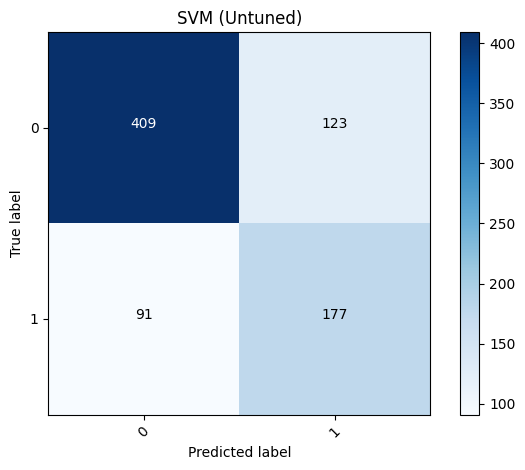

In [91]:
mod_svm = LinearSVC(tol = 0.1, class_weight={0:1, 1:2})
mod_svm.fit(x_train, y_train)
pred = mod_svm.predict(x_test)
classes=list(set(y_test))
print(f1_score(y_test, pred))
cm = confusion_matrix(y_test, pred, labels=classes)
plot_confusion_matrix(cm, classes=classes, title='SVM (Untuned)')
print(classification_report(y_test, pred))

Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       532
           1       0.59      0.59      0.59       268

    accuracy                           0.72       800
   macro avg       0.69      0.69      0.69       800
weighted avg       0.72      0.72      0.72       800



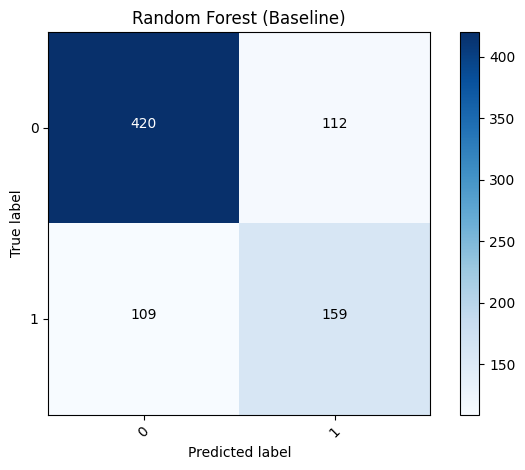

In [113]:
from sklearn.ensemble import RandomForestClassifier
mod_rf =RandomForestClassifier(class_weight={0: 0.5, 1: 2}, max_depth=100, n_estimators=200)
mod_rf.fit(x_train, y_train)
pred = mod_rf.predict(x_test)
cm = confusion_matrix(y_test, pred, labels=classes)
plot_confusion_matrix(cm, classes=classes, title='Random Forest (Baseline)')
print(classification_report(y_test, pred))

0.6187624750499001
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.80      0.85      0.83       532
           1       0.67      0.58      0.62       268

    accuracy                           0.76       800
   macro avg       0.73      0.72      0.72       800
weighted avg       0.76      0.76      0.76       800



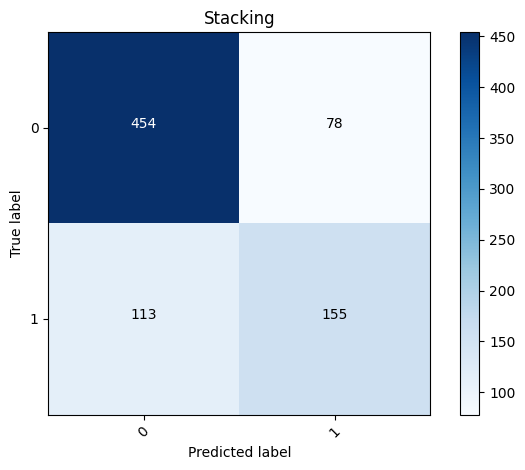

In [119]:
# criterion='entropy', max_depth=100, max_features='sqrt', n_estimators=400
from sklearn.ensemble import StackingClassifier
stack = [
     ('rf',RandomForestClassifier(class_weight='balanced', max_depth=50)),
     ('svc', SVC(C=10, kernel='linear')),
     ('linearscc', LinearSVC(tol = 0.1, class_weight={0:0.5, 1:2}))
]

mod_stack1 = StackingClassifier(estimators = stack)
mod_stack1.fit(x_train, y_train)
pred = mod_stack1.predict(x_test)
print(f1_score(y_test, pred))
cm = confusion_matrix(y_test, pred, labels=classes)
plot_confusion_matrix(cm, classes=classes, title='Stacking')
print(classification_report(y_test, pred))

In [ ]:
svc_param_list = {
     "C": [1]
}

gsc = GridSearchCV(SVC(), svc_param_list, scoring='f1', n_jobs=-1)
gsc.fit(x_test, y_test)
gsc.best_score_, gsc.best_estimator_

(LinearSVC(class_weight={0: 0.5, 1: 1}, tol=0.1), 0.6311038534686517)

In [ ]:
rf_param_list = {
     'max_depth': [10, 50, 100, 200, 400],
     'n_estimators': [10, 50, 100, 200, 400, 800],
     'criterion': ["gini", "entropy"],
     'class_weight': ["balanced", "balanced_subsample", {0:0.5, 1:3}]
}

gsc = GridSearchCV(RandomForestClassifier(), rf_param_list, scoring='accuracy', n_jobs=-1, verbose = 3)
gsc.fit(x_test, y_test)
gsc.best_score_, gsc.best_estimator_

In [ ]:
import xgboost as xgb

xgboost_param_list = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 5],
        'learning_rate': [0.001, 0.01, 0.1, 1, 2],
        'n_estimators': [100, 500, 1000]
        }

gsc = GridSearchCV(xgb.XGBClassifier(), xgboost_param_list, scoring='accuracy', n_jobs=-1, verbose=3)
gsc.fit(x_test, y_test)
gsc.best_score_, gsc.best_estimator_

In [ ]:
svc_param_list = {
    
}

gsc = GridSearchCV()

Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.78      0.77      0.78       532
           1       0.56      0.57      0.56       268

    accuracy                           0.70       800
   macro avg       0.67      0.67      0.67       800
weighted avg       0.71      0.70      0.71       800



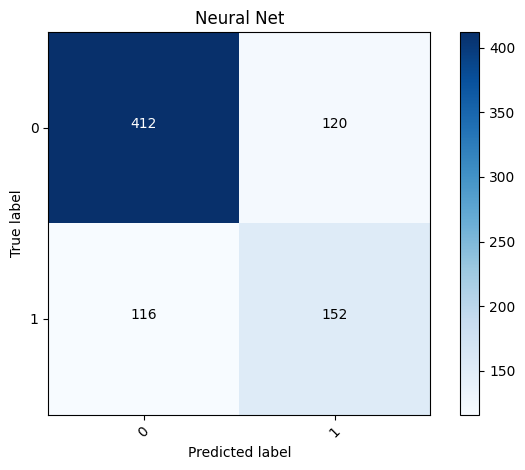

In [80]:
from sklearn.neural_network import MLPClassifier

# step 1: initial an classifier 
model_mlp = MLPClassifier(alpha=0.0001, max_iter=1500, solver = "adam")

# step 2: train the classifier by feeding train data (notes features + labels)
model_mlp.fit(x_train, y_train)

# step 3: prediction by feeding validation data (notes features only)
model_mlp = model_mlp.predict(x_test)

# step 4: check the performance of model by comparing the prediction and preserved labels.
cm = confusion_matrix(y_test, model_mlp, labels=classes)
plot_confusion_matrix(cm, classes=classes, title='Neural Net')

print(classification_report(y_test, model_mlp))

# Output

In [28]:
!iconv -f utf-8 -t utf-8 -c ./WN23_data/WN23_PA_test_tweets.txt > ./WN23_data/test.txt

In [39]:
sub_file = './WN23_data/test.txt'
sub_df = pd.read_csv(sub_file, sep = ",",encoding = "ISO-8859-1")
sub_df['Tweet'] = sub_df['Tweet'].apply(lambda x: regex_preprocessing(x)).apply(lambda x: text_preprocessing(x)).apply(lambda x: " ".join(x))
sub_text = sub_df['Tweet']
sub = vectorizr.transform(sub_text)
pred = mod_stack1.predict(sub)
final = pd.DataFrame({'TweetID': sub_df['TweetID'], 'Label': pred})
final.to_csv('submission1.csv', header=True, index=None, sep=',', mode='a')
!kaggle competitions submit -c lhs712-w23-activity-tweeting -f submission1.csv -m "baseline"